# ============================================================
# CONEXIÓN CON GOOGLE DRIVE
# ============================================================

In [ ]:
from google.colab import drive
drive.mount("/content/drive") # Se monta el Drive

from google.colab import files

Se instalan algunas librerías que Colab no tienen instaladas

In [ ]:
!pip install -U kaleido

In [3]:
from rpy2.robjects.packages import importr

In [ ]:
utils = importr("utils")
utils.install_packages("BiocManager")

BiocManager = importr("BiocManager") 
BiocManager.install("limma") 

limma = importr("limma")

# ============================================================
# USO DE FICHEROS .PY COMO MÓDULO EN COLAB
# ============================================================

In [5]:
!cp /content/drive/MyDrive/TFG/GeneFlow/src/dataobject.py /content
!cp /content/drive/MyDrive/TFG/GeneFlow/src/etl.py /content
!cp /content/drive/MyDrive/TFG/GeneFlow/src/model.py /content
!cp /content/drive/MyDrive/TFG/GeneFlow/src/objects.py /content
!cp /content/drive/MyDrive/TFG/GeneFlow/src/processing.py /content
!cp /content/drive/MyDrive/TFG/GeneFlow/src/utils.py /content
!cp /content/drive/MyDrive/TFG/GeneFlow/src/visualize.py /content

!cp /content/drive/MyDrive/TFG/GeneFlow/geneflow.py /content

# ============================================================
# IMPORTAMOS GENEFLOW
# ============================================================

In [6]:
import geneflow as genf

# ============================================================
# LECTURA DE LA MATRIZ DE CONTEO
# ============================================================

Problema propuesto en el paper: **EGF-mediated induction of Mcl-1 at the switch to lactation is essential for alveolar cell survival**, de *Nature Cell Biology* (2015) [ https://www.nature.com/articles/ncb3117 ]

Se han seguido los pasos del curso impartido para las *VI Jornadas de BIO-INFORMÁTICA* (2022): **Aprende R para Análisis de Expresión de ARN**. Dirigido por Carlos Cano Gutiérrez y María Coral del Val Muñoz. [ https://vijornadas.ugrbioinformatics.com/ ]


El objetivo es analizar los transcriptomas de células basales y luminales en las glándulas mamarias de ratonas embarazadas, con descendencia lactante y sin descendencia, teniendo un total de 12 muestras para el estudio.


La matriz de conteo indica el número de copias para cada loci.

In [7]:
df = genf.read_file("/content/drive/MyDrive/TFG/GeneFlow/data/countdata.txt", index = "Gene_ID")

df.head()

,MCL1.DG,MCL1.DH,MCL1.DI,MCL1.DJ,MCL1.DK,MCL1.DL,MCL1.LA,MCL1.LB,MCL1.LC,MCL1.LD,MCL1.LE,MCL1.LF
Gene_ID,,,,,,,,,,,,
497097,438,300,65,237,354,287,0,0,0,0,0,0
100503874,1,0,1,1,0,4,0,0,0,0,0,0
100038431,0,0,0,0,0,0,0,0,0,0,0,0
19888,1,1,0,0,0,0,10,3,10,2,0,0
20671,106,182,82,105,43,82,16,25,18,8,3,10


# ============================================================
# LECTURA DE LA INFORMACIÓN CLÍNICA ASOCIADA
# ============================================================

Este fichero contiene información básica sobre las doce muestras del análisis (nombre de la muestra, tipo celular y estado).

In [8]:
df_samples = genf.read_file("/content/drive/MyDrive/TFG/GeneFlow/data/SampleInfo_Corrected.txt", index = "SampleName")

df_samples.head()

,FileName,CellType,Status
SampleName,,,
MCL1.DG,MCL1.DG_BC2CTUACXX_ACTTGA_L002_R1,basal,virgin
MCL1.DH,MCL1.DH_BC2CTUACXX_CAGATC_L002_R1,basal,virgin
MCL1.DI,MCL1.DI_BC2CTUACXX_ACAGTG_L002_R1,basal,pregnant
MCL1.DJ,MCL1.DJ_BC2CTUACXX_CGATGT_L002_R1,basal,pregnant
MCL1.DK,MCL1.DK_BC2CTUACXX_TTAGGC_L002_R1,basal,lactate


# ============================================================
# CREACIÓN DEL OBJETO DATAOBJECT
# ============================================================

El objeto DataObject se crea con la información coincidente de la matriz de conteo y la información clínica de las muestras asociadas.

In [9]:
data_object = genf.create_data_object(df,obs_ = df_samples)

data_object.summary_object()


Creating DataObject...


##############################################

Data Object
	Dimensions:  (27179, 12)
	Row Names (27179): 497097 ... 100504472
	Column Names (12): MCL1.DG ... MCL1.LF

	Var
		There is no data for Var

	Obs
		Dimensions:  (12, 3)
		Row Names (12): MCL1.DG ... MCL1.LF
		Column Names (3): FileName ... Status

##############################################


# ============================================================
# DIAGRAMA DE BARRAS
# ============================================================

Se muestra un diagrama de barras (bar plot) con el número de lecturas para cada muestra.

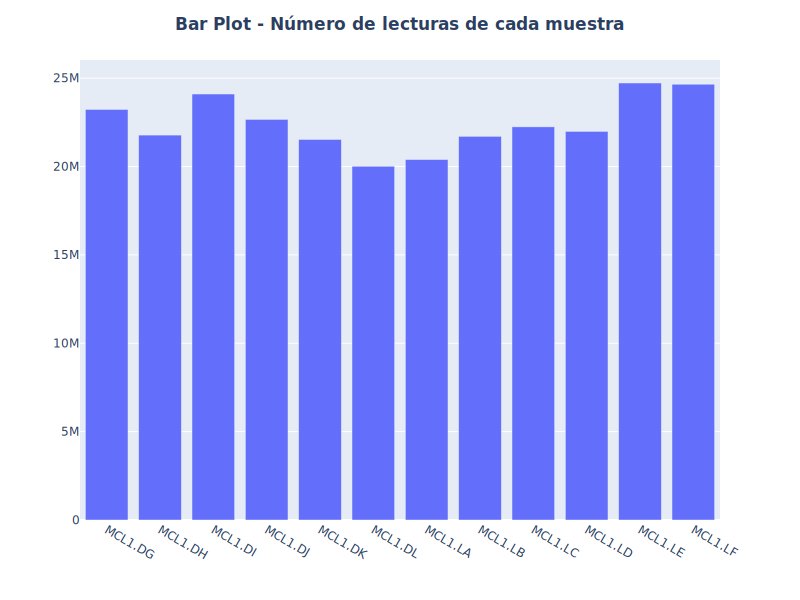

In [10]:
bar = genf.bar_plot(data_object.get_counts())

genf.show_figure(bar, xlabel="", ylabel="", legend = False, title="Bar Plot - Número de lecturas de cada muestra")


# ============================================================
# FILTRADO PARA ELIMINAR GENES NO EXPRESADOS
# ============================================================

Una técnica para mejorar la potencia estadística de los test que potencialmente se apliquen sobre los datos es eliminar los genes que apenas se expresan en ninguna de las muestras.

Para calcular los genes con un bajo número de copias en las muestras, se suele emplear una escala de medida de número de copias de un gen (loci) por millón de lecturas (counts per million, CPM). 

In [11]:
cpm = genf.cpm(data_object.get_counts())

cpm.head()

,MCL1.DG,MCL1.DH,MCL1.DI,MCL1.DJ,MCL1.DK,MCL1.DL,MCL1.LA,MCL1.LB,MCL1.LC,MCL1.LD,MCL1.LE,MCL1.LF
Gene_ID,,,,,,,,,,,,
497097,18.856844,13.775439,2.697010,10.456480,16.442685,14.338969,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
100503874,0.043052,0.000000,0.041492,0.044120,0.000000,0.199846,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
100038431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
19888,0.043052,0.045918,0.000000,0.000000,0.000000,0.000000,0.490386,0.138197,0.449608,0.090958,0.00000,0.00000
20671,4.563528,8.357099,3.402382,4.632618,1.997275,4.096848,0.784617,1.151641,0.809294,0.363831,0.12134,0.40556


De esta forma, solo los loci que presentan un número de lecturas mayor que el un umbral, establecido a 0.5, serán seleccionados. Para este análisis, se ha seleccionado aquellos genes con 0.5 CPM en, al menos, dos de las muestras. 

In [13]:
threshs = genf.remove_low_reads(cpm, thresh = 0.5)

threshs.head()

print("Dimensiones\n\n")
print(threshs.shape)

Dimensiones


(15804, 12)


Se realizará una selección (es decir, nos quedaremos con un sub-DataFrame de nuestra matriz de conteo) basándonos en el filtro generado con 'threshs'. Tras esto, se actualizará en objeto DataObject para seguir utilizándolo en el análisis.

In [14]:
subdf = genf.data_selection_filter(data_object.get_counts(), filter_= threshs)

proc_df = genf.drop_values(subdf, axis = 1)

genf.set_counts(data_object, proc_df)

# ============================================================
# GRÁFICAS DE ANÁLISIS DE DISTRIBUCIONES Y CONTROL DE CALIDAD
# ============================================================

Para observar las distribuciones de expresión para cada muestra con más claridad, se aplicará de nuevo la normalización CPM, pero con una transformación logarítmica.

In [15]:
data_object = genf.counts_cpm(data_object, log_method = True)

(data_object.get_counts()).head()

,MCL1.DG,MCL1.DH,MCL1.DI,MCL1.DJ,MCL1.DK,MCL1.DL,MCL1.LA,MCL1.LB,MCL1.LC,MCL1.LD,MCL1.LE,MCL1.LF
Gene_ID,,,,,,,,,,,,
497097,4.244422,3.793984,1.478856,3.399132,4.047669,3.851326,-3.486175,-3.486175,-3.486175,-3.486175,-3.486175,-3.486175
20671,2.218675,3.078965,1.804432,2.239895,1.061563,2.066100,-0.194052,0.311941,-0.154020,-1.141904,-2.247422,-1.014878
27395,3.743931,3.438146,3.815321,3.736642,3.761690,3.763796,4.784557,4.424446,4.464717,3.907855,3.644835,3.803414
18777,4.816132,4.569714,5.301554,5.370072,5.433221,5.308258,5.343766,5.315238,4.913168,4.881465,4.465712,4.564158
21399,6.112147,6.103657,6.160375,5.863386,5.753311,5.737877,6.034104,5.859592,5.588558,5.399622,4.367347,4.348429


Se calcula un gráfico de estimación de densidad de kernel (KDE). Este método permite la visualización de la distribución de las observaciones de un conjunto de datos.

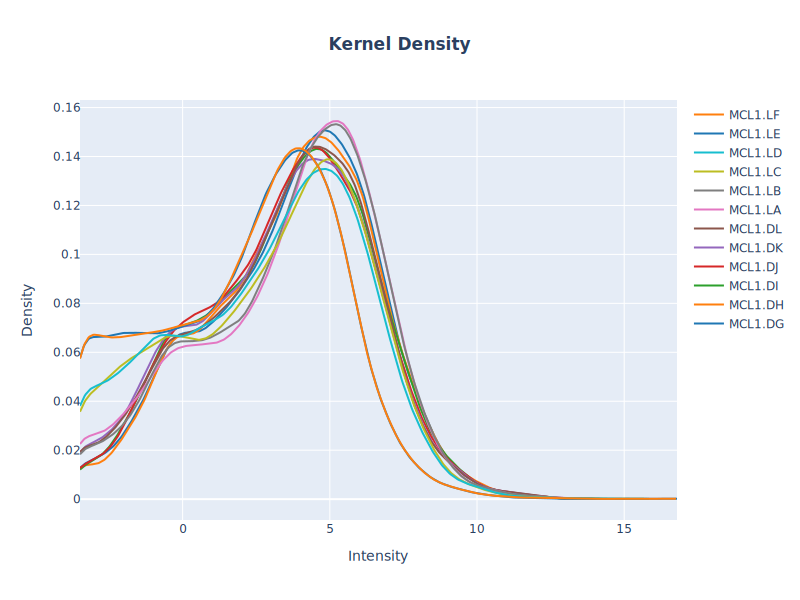

In [16]:
kde = genf.kde_plot(data_object.get_counts())

genf.show_figure(kde, xlabel="Intensity", ylabel="Density", title="Kernel Density")

Se compara, además, las distribuciones de todas las muestras con boxplots (gráfico de cajas). También se pinta una línea horizontal para la mediana de los logCPM.

Con el gráfico de cajas, podemos observar que la distribución de los logCPM no es idéntica entre unas muestras y otras, pero son lo suficientemente parecidas para considerarlas en un análisis conjunto. 

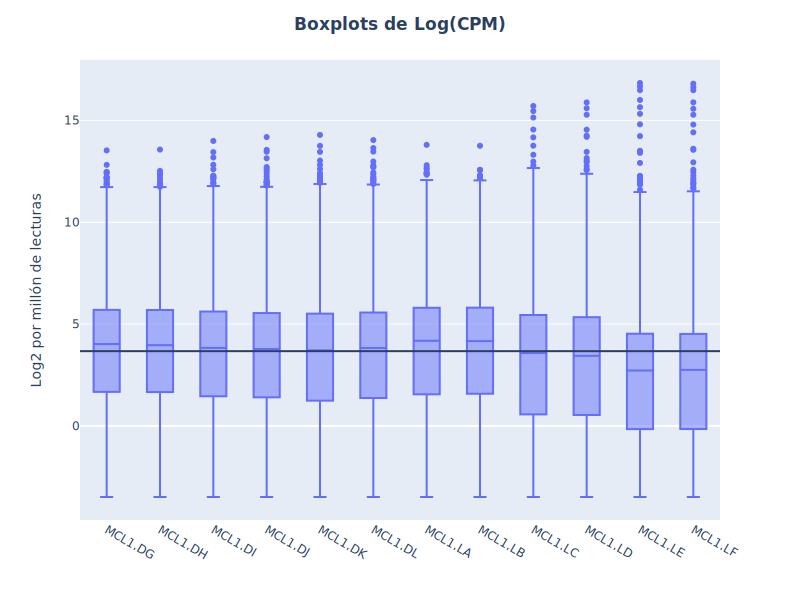

In [17]:
box = genf.box_plot(data_object.get_counts(), median = True)

genf.show_figure(box, xlabel="", ylabel="Log2 por millón de lecturas", title="Boxplots de Log(CPM)")

# ============================================================
# DIAGRAMA DE ESCALAMIENTO MULTIDIMENSIONAL (MDS)
# ============================================================

Una de las visualizaciones más interesantes para analizar datos de RNA-Seq son los diagramas multidimensionales (MDS). Con ellos, se puede visualizar un análisis de componentes principales para determinar las variables que introducen una mayor fuente de variación en los datos.

Este tipo de gráficos también permite detectar outliers en los datos.

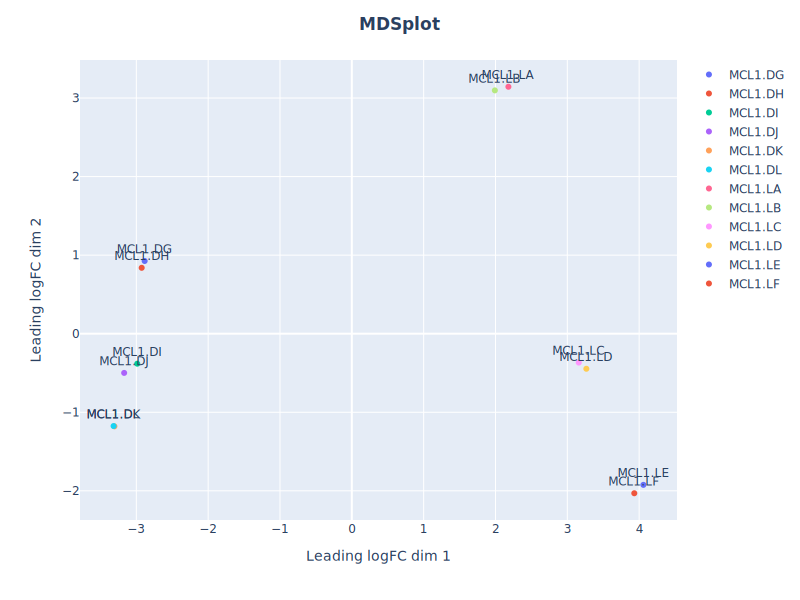

In [18]:
mds = genf.mds_plot(data_object.get_counts())

genf.show_figure(mds, xlabel="Leading logFC dim 1", ylabel="Leading logFC dim 2", title="MDSplot")


Para hacer el gráfico más informativo, se colorean las muestras según el tipo de línea celular asociada (basal o luminal), haciendo uso del conjunto OBS del objeto DataObject, el cual alamacena los metadatos de las muestras.

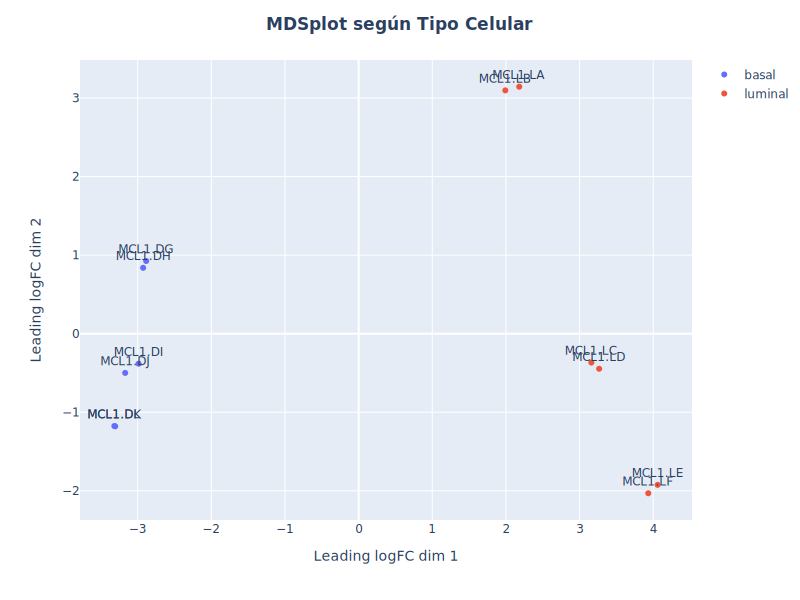

In [19]:
cell_types = genf.data_projection_name(data_object.get_obs(), "CellType")

mds_type = genf.mds_plot(data_object.get_counts(), clinical_info = cell_types)

genf.show_figure(mds_type, xlabel="Leading logFC dim 1", ylabel="Leading logFC dim 2", title="MDSplot según Tipo Celular")

genf.save_image(mds_type, fig_name = "mdscell", img_format = "pdf", xlabel="Leading logFC dim 1", ylabel="Leading logFC dim 2", title="MDSplot según Tipo Celular")


Se realiza el mismo proceso y se colorean las muestras según su estado (lactante, embarazada, o virgen).

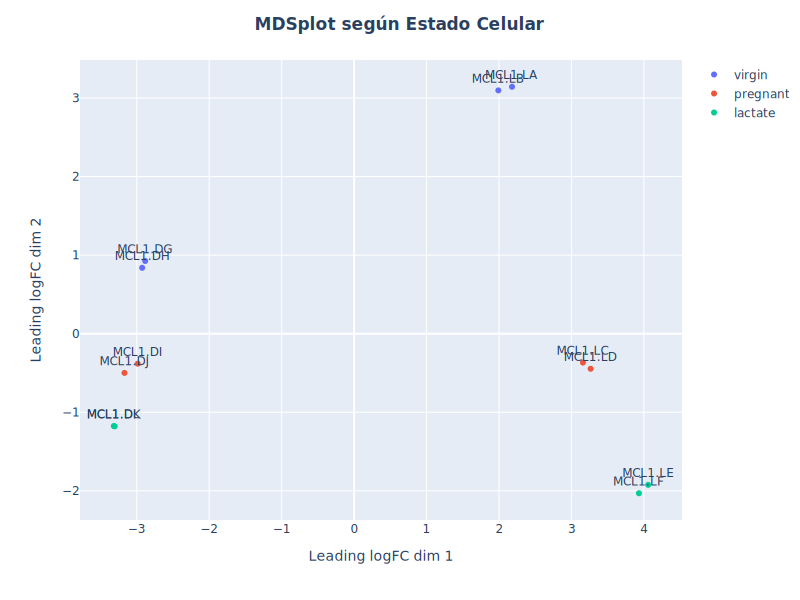

In [20]:
cell_status = (data_object.get_obs()).loc[:, "Status"].values

mds_status = genf.mds_plot(data_object.get_counts(), clinical_info = cell_status)

genf.show_figure(mds_status, xlabel="Leading logFC dim 1", ylabel="Leading logFC dim 2", title="MDSplot según Estado Celular")


# ============================================================
# CLUSTERING JERÁRQUICO CON CLUSTERMAPS
# ============================================================

Para realizar un análisis de las relaciones entre las muestras del estudio se puede utilizar un Clustering Jerárquico. Los mapas de calor o heatmaps son una visualización muy útil para observar las relaciones entre muestras y genes. 

En este caso, se calcula una matriz de distancia euclídea a partir de los recuentos de logCPPM para los 500 genes con más varianza entre unas muestras y otras. Además, a los datos se le aplicará una normalización por filas (Z-score).

In [21]:
# Se elige los 500 mejores genes. Criterio: se ordena de mayor a menor varianza.
select_var = genf.top_variables(data_object.get_counts(), 500)

select_var.head()

,MCL1.DG,MCL1.DH,MCL1.DI,MCL1.DJ,MCL1.DK,MCL1.DL,MCL1.LA,MCL1.LB,MCL1.LC,MCL1.LD,MCL1.LE,MCL1.LF
Gene_ID,,,,,,,,,,,,
22373,0.466067,0.911384,7.435080,7.807900,9.288318,9.318483,6.627745,6.688410,12.127332,13.150258,15.648100,15.569686
12797,10.042971,9.697797,11.046567,11.358857,11.605894,11.491773,0.852977,1.603460,2.332337,2.460107,0.805569,1.288003
11475,12.384900,12.324709,13.989573,14.180048,14.285489,14.032486,3.482340,4.370824,5.211657,5.078844,3.699765,3.965775
11468,7.153729,6.891770,9.325436,9.661942,9.491765,9.424803,-1.808608,-0.638758,0.524477,0.669405,-0.441250,-1.014878
14663,1.971761,1.947185,9.091895,8.756261,9.539747,9.504098,6.171036,6.232826,13.757193,14.250676,16.002084,15.885390


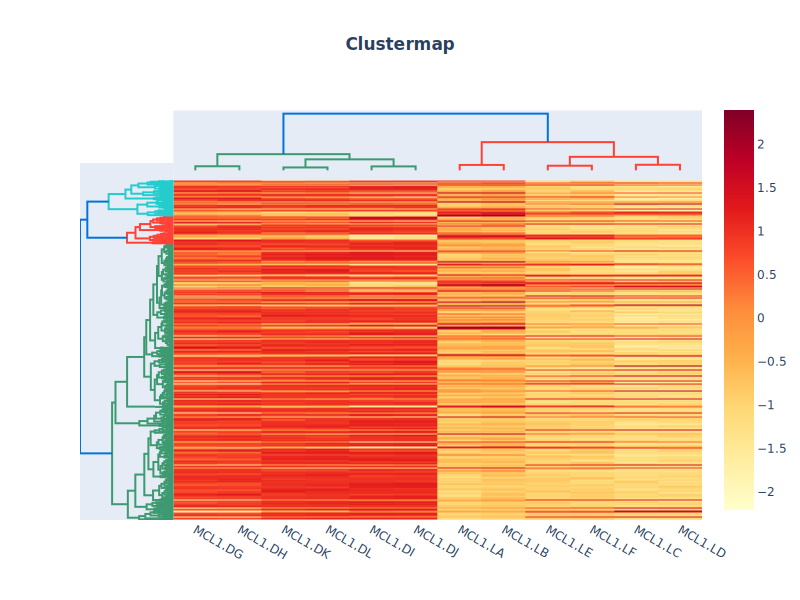

In [22]:
clsmap = genf.clustermap(select_var)

genf.show_figure(clsmap, xlabel = "", ylabel = "", legend = False, title = "Clustermap")

# ============================================================
# OBTENCIÓN DE GENES ESTADÍSTICAMENTE SIGNIFICATIVOS
# ============================================================

Ahora tenemos 500 genes que tienen una expresión diferencial, El siguiente paso, es saber qué genes son los que están más diferenciados que el resto. Para ello, se calcula un gráfico de Volcán (Volcano plot), es decir, un diagrama de dispersión utilizado para identificar rápidamente cambios en grandes conjuntos de datos.

Este diagrama muestra la significación estaística (p-value) frente a la magnitud del cambio (fold-change), permitiendo una identificación visual rápida de genes estadísticamente significativos biológicamente.

Los genes más regulados hacia arriba están a la derecha, y los genes más regulados hacia abajo están hacia la izquierda. Aquellos genes estadísticamente más significativos están dispersos hacia arriba.


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log2



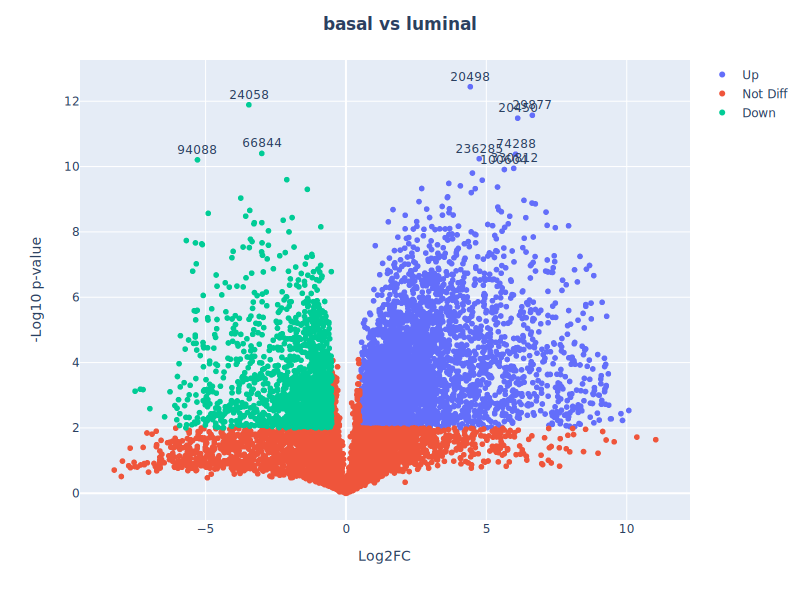

In [23]:
volcano = genf.volcano_plot(proc_df, "CellType", "basal", "luminal", df_samples)

genf.show_figure(volcano, xlabel="Log2FC", ylabel="-Log10 p-value", title = "{} vs {}".format("basal", "luminal"))